__Group E - Datalin__
- Alice Vale R20181074  
- Eva Ferrer R20181110  
- Rafael Sequeira R20181128  
- Raquel Sousa R20181102

#### Install Missing Libraries

In [ ]:
# ! pip install mixtend
# ! pip install LibRecommender
# ! pip install lightfm
# !pip install implicit

In [1]:
import datetime

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix, csr_matrix

import lightfm
import implicit 
from implicit.nearest_neighbours import bm25_weight

from mlxtend.frequent_patterns import apriori, association_rules

D:\Rafael\Anaconda_Setup\envs\Personal\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


#### Set graphs style

In [104]:
sns.set_style('whitegrid')

### Import data

In [2]:
data = pd.read_csv('retail.csv')

In [156]:
#information about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [160]:
#statistical description
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,536641,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,536641,4070,85123A,2301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,535187,4223,WHITE HANGING HEART T-LIGHT HOLDER,2357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,536641,NaN,NaN,NaN,9.62003,219.13,-80995,1,3,10,80995
InvoiceDate,536641,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,536641,NaN,NaN,NaN,4.63266,97.2331,-11062.1,1.25,2.08,4.13,38970
CustomerID,401604,NaN,NaN,NaN,15281.2,1714.01,12346,13939,15145,16784,18287
Country,536641,38,United Kingdom,490300,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Data Cleaning 

The data cleaning stage is composed by the following tasks:

- Drop Duplicates  
- Missing Value Examination
- Fix wrong descriptions    
- Incoherence Checking   
- Feature Engineer  

#### Check for duplicates

In [4]:
print(f'There are {data.loc[data.duplicated()].shape[0]} duplicated rows')

There are 5268 duplicated rows


In [6]:
#drop duplicates
init_len0 = len(data)
data = data.loc[~data.duplicated(keep='first')]
fin_len0 = len(data)
print(f'{np.round(1 - (fin_len0/init_len0),3)}% of the data were duplicates and was removed.')
#create a copy of the original DF for data preparation/cleaning
data_clean = data.copy()

0.01% of the data were duplicates and was removed.


In [8]:
products_list = data['StockCode'].unique()
customers_list = data['CustomerID'].unique()
nr_transaction = data['InvoiceNo'].unique()
print(f'The store has {len(products_list)} products and {len(customers_list)} customers')
print(f'{len(nr_transaction)} transactions happened in the store.')

The store has 4070 products and 4373 customers
25900 transactions happened in the store.


#### Missing Values

In [109]:
#checking missing values
data_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

#### Create Stock Signature to match descriptions 

In [3]:
#create signature 
# stock = pd.DataFrame()
# description = []
# stockid = []
# for i in data['StockCode'].unique():
#     #check all description names that occures with a single stockcode
#     value_df = data.loc[(data['StockCode']==f'{i}') & (data['Description'].isnull()==False)]
      
#     if len(value_df)>0:
          #get the most frequent description and associate it with the respective stockcode
#         value = value_df['Description'].value_counts().index[0]
#         stockid.append(i)
#         description.append(value)
    
# stock['StockCode'] = stockid
# stock['Description'] = description

# stock.to_csv(r'Stock_description.csv')
stock = pd.read_csv(r'Stock_description.csv')
stock.head(3)

,Unnamed: 0,StockCode,Description
0,0,85123A,WHITE HANGING HEART T-LIGHT HOLDER
1,1,71053,WHITE METAL LANTERN
2,2,84406B,CREAM CUPID HEARTS COAT HANGER


In [7]:
# drop old description and merge the new description from the stock df
data_clean.drop(columns=['Description'],inplace=True)
data_clean = pd.merge(data_clean,stock.reset_index()[['StockCode','Description']],how='left', on='StockCode')

In [337]:
#check missing values
# missing values dropped from 1454 to 112
data_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
Description       112
dtype: int64

#### Create invoice signature to match IDs

In [ ]:
#create signature 
# invoice = pd.DataFrame()
# custid = []
# invoiceid = []
# for i in data['InvoiceNo'].unique():
#     #check all customerIDs that occures with a single invoiceNo
#     value_df = data.loc[(data['InvoiceNo']==f'{i}') & (data['CustomerID'].isnull()==False)]
      #get the most frequent CustomerID and associate it with the respective Invoice
#     if len(value_df)>0:
#         value = value_df['CustomerID'].value_counts().index[0]
#         invoiceid.append(i)
#         custid.append(value)
    
# invoice['InvoiceNo'] = invoiceid
# invoice['CustId'] = custid

#invoice.to_csv('Invoice_Customer_Match.csv')
invoice = pd.read_csv('Invoice_Customer_Match.csv')

In [8]:
data_clean['CustId'] = data_clean['CustomerID']
data_clean.drop(columns=['CustomerID'],inplace=True)
#data_clean__ = pd.merge(data_clean,invoice[['InvoiceNo','CustId']],how='left', on='InvoiceNo')

In [8]:
#Final Missing Values
data_clean.isnull().sum()

InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
Description       112
CustId         135037
dtype: int64

#### Incoherences

In [10]:
data_clean.loc[data_clean['InvoiceNo'].str.startswith('C'),:]

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,Description,CustId
141,C536379,D,-1,12/1/2010 9:41,27.50,United Kingdom,Discount,14527.0
154,C536383,35004C,-1,12/1/2010 9:49,4.65,United Kingdom,SET OF 3 COLOURED FLYING DUCKS,15311.0
235,C536391,22556,-12,12/1/2010 10:24,1.65,United Kingdom,PLASTERS IN TIN CIRCUS PARADE,17548.0
236,C536391,21984,-24,12/1/2010 10:24,0.29,United Kingdom,PACK OF 12 PINK PAISLEY TISSUES,17548.0
237,C536391,21983,-24,12/1/2010 10:24,0.29,United Kingdom,PACK OF 12 BLUE PAISLEY TISSUES,17548.0
...,...,...,...,...,...,...,...,...
535188,C581490,23144,-11,12/9/2011 9:57,0.83,United Kingdom,ZINC T-LIGHT HOLDER STARS SMALL,14397.0
536280,C581499,M,-1,12/9/2011 10:28,224.69,United Kingdom,Manual,15498.0
536447,C581568,21258,-5,12/9/2011 11:57,10.95,United Kingdom,VICTORIAN SEWING BOX LARGE,15311.0
536448,C581569,84978,-1,12/9/2011 11:58,1.25,United Kingdom,HANGING HEART JAR T-LIGHT HOLDER,17315.0


In [9]:
init_len = len(data_clean)
data_clean = data_clean.loc[data_clean['StockCode'].str.contains('POST') ==False]
data_clean = data_clean.loc[data_clean['StockCode'].str.contains('DOT')==False]
data_clean = data_clean.loc[data_clean['Description'].str.contains('Manual')==False]
data_clean = data_clean.loc[data_clean['Description'].str.contains('SAMPLE')==False]
data_clean = data_clean.loc[data_clean['Description'].str.contains('lost')==False]
#transactions with negative units that arent' canceled
index = data_clean.loc[(data_clean['Quantity']<0 )& (data_clean['InvoiceNo'].str.startswith('C')==False)].index
data_clean = data_clean.loc[data_clean.index.isin(index)==False]
data_clean = data_clean.loc[data_clean['StockCode'].isin(['CRUK','D','BANK CHARGES','B','AMAZONFEE'])==False]
data_clean = data_clean.loc[(data_clean['Description'] == 'CARRIAGE')==False]
data_clean = data_clean.loc[data_clean['UnitPrice']>0]

#create variable to find the canceled invoices and respectives transactions
# data_clean['Cust_Stock'] = data_clean['CustId'].astype(str) + data_clean['StockCode']
#data_clean = data_clean.loc[data_clean['Cust_Stock'].isin(data_clean.loc[data_clean['InvoiceNo'].str.startswith('C'),'Cust_Stock'].unique())==False]

fin_len = len(data_clean)
removed = np.round((1- (fin_len/init_len))*100,3)
print(f'{removed}% of the dataset was removed')

1.007% of the dataset was removed


In [12]:
teste = data_clean.loc[data_clean['Cust_Stock'].isin(data_clean.loc[data_clean['InvoiceNo'].str.startswith('C'),'Cust_Stock'].unique())==False]
teste.loc[teste['InvoiceNo']=='C581484']

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,Country,Description,CustId,Cust_Stock


In [10]:
#changing countries names to make the analysis more clear
data_clean.loc[data_clean['Country']=='EIRE','Country'] = 'Ireland'
data_clean.loc[data_clean['Country']=='RSA','Country'] = 'South_Africa'

#### Note on outliers:
Since it's a recommendation system we will not remove any outliers from the dataset 

#### Feature Engineer

In [11]:
#transform invoiceDate to Datetime
data_clean['InvoiceDate'] = pd.to_datetime(data_clean['InvoiceDate'],dayfirst=True)
#create month variable 
data_clean['Month'] = data_clean['InvoiceDate'].dt.month
#create date variable
data_clean['InvDate'] = data_clean['InvoiceDate'].dt.date

# create transaction value 
data_clean['Transaction_Value'] = data_clean['Quantity'] * data_clean['UnitPrice']

#indicates the hour of the transaction
data_clean['hour'] = data_clean['InvoiceDate'].dt.hour

#indicates the period of the day in which the transaction occured
for i,ii,iii in zip([7,12,17],[12,17,24],['Morning','Afternoon','Noon']):
    data_clean.loc[(data_clean['hour']>=i) & (data_clean['hour']<ii),'Day_Range'] = iii
    
#indicates the season of the year in which the transaction occured    
data_clean.loc[data_clean['Month'].isin([12,1,2]),'Season'] = 'Winter'
data_clean.loc[data_clean['Month'].isin([9,10,11]),'Season'] = 'Autumn'
data_clean.loc[data_clean['Month'].isin([3,4,5]),'Season'] = 'Spring'
data_clean.loc[data_clean['Month'].isin([6,7,8]),'Season'] = 'Summer'

Text(0.5, 1.0, 'Number of Customers and Products')

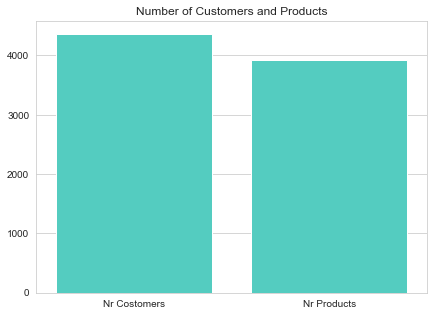

In [105]:
plt.figure(figsize = (7,5))
axis = sns.barplot(y= [len(data_clean['CustId'].unique()),len(data_clean['StockCode'].unique())],x = ['Nr Costomers', 'Nr Products'],palette=['Turquoise'])
plt.title('Number of Customers and Products')

Text(0, 0.5, 'Total Sales')

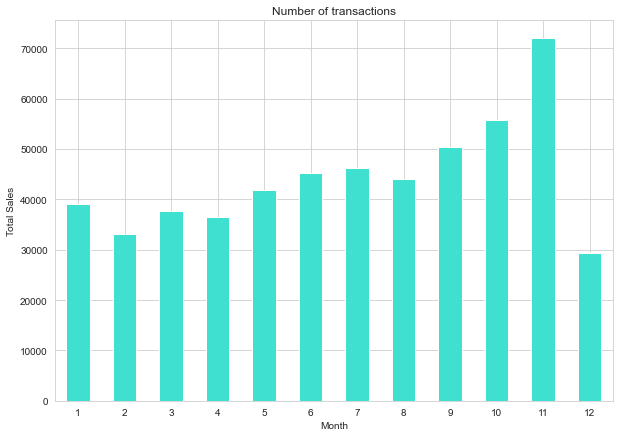

In [106]:
(data_clean.groupby('Month').count()['Transaction_Value']).plot.bar(figsize = (10,7),color = 'Turquoise')
plt.xticks(rotation = 0)
plt.title('Number of transactions')
plt.ylabel('Total Sales')

In [108]:
month_index = data_clean.groupby('Month').sum()['Transaction_Value'].index
month_analysis = pd.DataFrame(index = month_index)
total_month = data_clean.groupby('Month').sum()['Transaction_Value']
count_month = data_clean.groupby(['Month','InvoiceNo']).count()['Transaction_Value'].groupby('Month').count()
month_analysis['Total_Value'] = total_month
month_analysis['Nr_Transactions'] = count_month

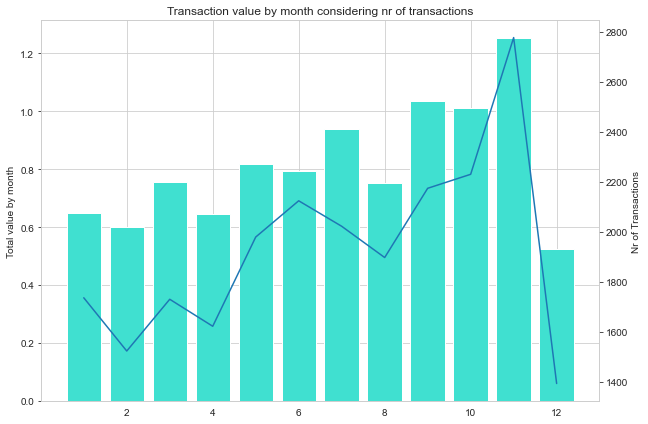

In [109]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.bar( x =month_analysis.index , height = month_analysis['Total_Value']/1000000,color = 'Turquoise')
ax1.set_ylabel('Total value by month')

ax2 = ax1.twinx()
ax2.plot( month_analysis['Nr_Transactions'])
ax2.set_ylabel('Nr of Transactions')
plt.title('Transaction value by month considering nr of transactions')

ax2.grid(False)

Text(0, 0.5, 'Total Sales')

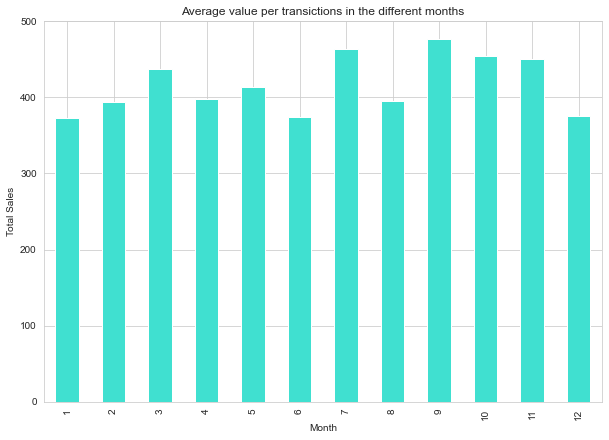

In [110]:
(month_analysis['Total_Value'] / month_analysis['Nr_Transactions']).plot.bar(figsize = (10,7),color = 'Turquoise')
plt.title('Average value per transictions in the different months')
plt.ylabel('Total Sales')

Text(0, 0.5, 'Total Sales')

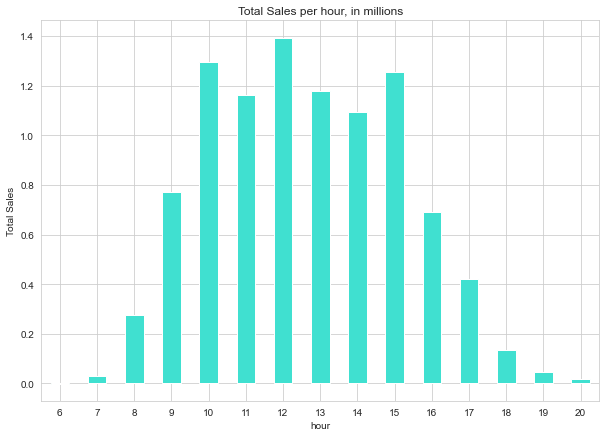

In [111]:
(data_clean.groupby('hour').sum()['Transaction_Value']/1000000).plot.bar(figsize = (10,7),color = 'Turquoise')
plt.xticks(rotation = 0)
plt.title('Total Sales per hour, in millions')
plt.ylabel('Total Sales')

Text(0, 0.5, 'Number of transactions')

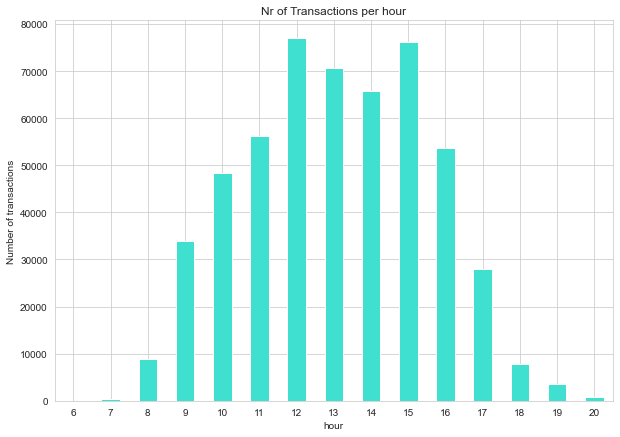

In [112]:
(data_clean.groupby('hour').count()['InvoiceNo']).plot.bar(figsize = (10,7),color = 'Turquoise')
plt.xticks(rotation = 0)
plt.title('Nr of Transactions per hour')
plt.ylabel('Number of transactions')

### Signatures

#### Create Customer Signature

In [12]:
cust_sig = pd.DataFrame()
country = data_clean.groupby(['CustId'])['Country'].agg(pd.Series.mode)
nr_transactions = pd.Series(data_clean.groupby(['CustId','InvoiceNo']).count().groupby('CustId').count()['StockCode'],name='Nr_Purchases')
total_value = data_clean.groupby(['CustId']).sum()['Transaction_Value']

In [13]:
cust_sig['Country'] = country
cust_sig['Nr_Transactions'] = nr_transactions
cust_sig['Total_Value'] = total_value
cust_sig['Avg_Value_Transcation'] = total_value/nr_transactions

cust_sig['Products_Bough'] = pd.Series(data_clean.groupby(['CustId','StockCode']).count().groupby('CustId').count()['Quantity'],name = 'Products_Bought')
cust_sig.sort_values(ascending=False,by='Total_Value',inplace=True)
#cust_sig['Products_Bought'] = pd.Series(data_clean.groupby(['CustId','StockCode']).count().groupby('CustId').count()['Quantity'],name = 'Products_Bought')
cust_sig['pct_value'] = cust_sig['Total_Value'] / cust_sig['Total_Value'].sum()
cust_sig['pct_pop'] = 1 / len(cust_sig)
cust_sig['New_Customer_ID'] = np.arange(1, len(cust_sig)+1)
cust_sig['Cumulative_Value'] = cust_sig['pct_value'].cumsum()
cust_sig['Cumulative_pop'] = cust_sig['pct_pop'].cumsum()

In [14]:
cust_leverage = pd.DataFrame(index = ['HighValue','MediumValue','LowValue'])
high_value = cust_sig.loc[cust_sig['Cumulative_pop']<=0.3,'Total_Value'].sum()
medium_value = cust_sig.loc[(cust_sig['Cumulative_pop']>0.3) & (cust_sig['Cumulative_pop']<=0.5),'Total_Value'].sum()
low_value = cust_sig.loc[(cust_sig['Cumulative_pop']>0.5),'Total_Value'].sum()
values = [high_value,medium_value,low_value]
cust_leverage['Value'] = values
cust_leverage['Pop_pct'] = [0.3,0.2,0.5]
total_value = cust_sig.loc[:,'Total_Value'].sum()
cust_leverage['Value_pct'] = cust_leverage['Value']/total_value

In [15]:
cust_leverage['Leverage'] = cust_leverage['Value_pct']/ cust_leverage['Pop_pct']

Text(0, 0.5, 'Leverage')

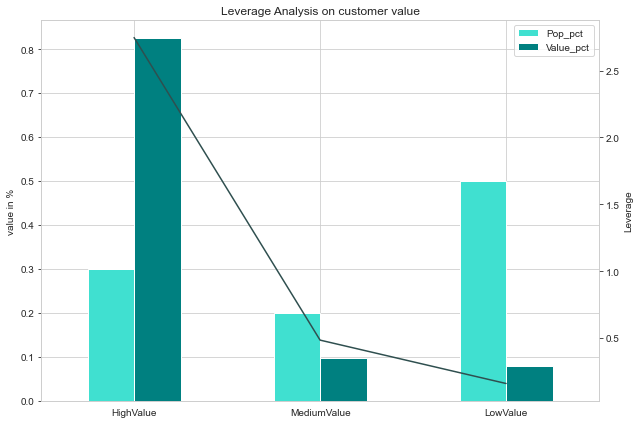

In [120]:
ax1 = cust_leverage[['Pop_pct','Value_pct']].plot.bar(figsize = (10,7),color = ['Turquoise','teal'])
ax2= cust_leverage['Leverage'].plot.line(secondary_y=True,color = 'darkslategray',)
plt.title('Leverage Analysis on customer value')
ax2.grid(False)
ax1.grid(True)
ax1.set_ylabel('value in %')
ax2.set_ylabel('Leverage')



Text(0.5, 1.0, 'Product Leverage')

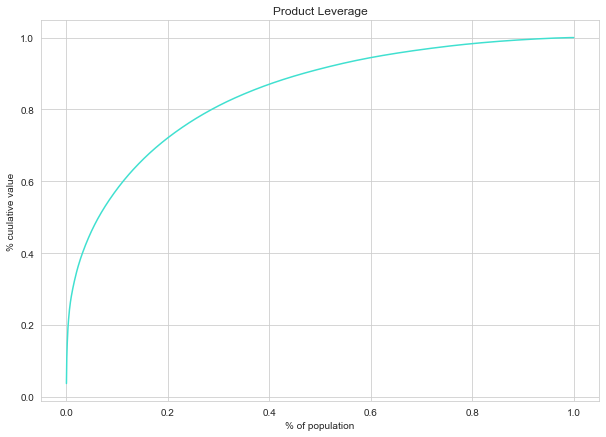

In [104]:
plt.figure(figsize = (10,7))
axis = sns.lineplot(y=cust_sig['Cumulative_Value'],x=cust_sig['Cumulative_pop'],color='Turquoise')
axis.set_ylabel('% cuulative value')
axis.set_xlabel('% of population')
plt.title('Product Leverage')

#### Product Signature

In [16]:
#countring the nr of times a product is bought
nr_times = data_clean.groupby(['StockCode','InvoiceNo']).count().groupby('StockCode').count()['Quantity']

#getting the description of the products
description = data_clean.groupby(['StockCode'])['Description'].agg(pd.Series.mode)

#getting avg unit price of a product
avg_price = data_clean.groupby(['StockCode'])['UnitPrice'].mean()

#getting how many units were bought
total_unit = data_clean.groupby(['StockCode'])['Quantity'].sum()

#getting the avg nr of units per transaction 
avg_unit = data_clean.groupby(['StockCode'])['Quantity'].mean()

#getting the total value generated by a product
total_value = data_clean.groupby(['StockCode'])['Transaction_Value'].sum()

In [17]:
#creating a DF with the data generated above 
product_sign = pd.DataFrame()
product_sign['Description'] = description
product_sign['Times_Bought'] = nr_times

product_sign['Avg_price'] = avg_price
product_sign['Total_Value'] = total_value
product_sign['avg_units'] = avg_unit

#create new product ID 
product_sign['New_Product_ID'] = np.arange(1,len(product_sign)+1)

#Leverage Analysis
#sorting product by most valuable
product_sign.sort_values(ascending=False,by='Total_Value',inplace=True)

#getting the percentage of value generated by a single product 
product_sign['pct_value'] = product_sign['Total_Value'] / product_sign['Total_Value'].sum()

#getting the percentage of a single product in terms of the population of products
product_sign['pct_pop'] = 1 / len(product_sign)

#calculate cumulative sum
product_sign['Cumulative_Value'] = product_sign['pct_value'].cumsum()
product_sign['Cumulative_pop'] = product_sign['pct_pop'].cumsum()

Text(0.5, 1.0, 'Product Leverage')

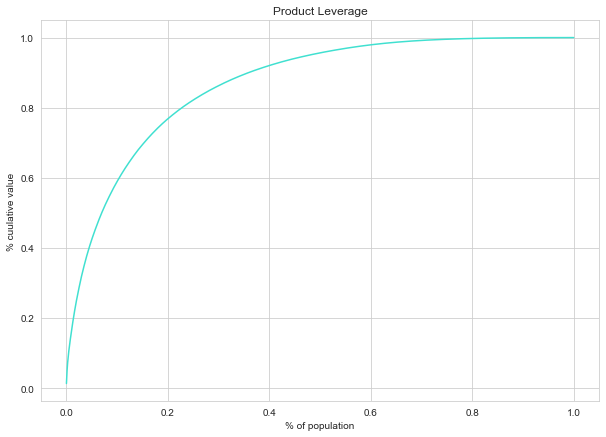

In [17]:
plt.figure(figsize = (10,7))
axis = sns.lineplot(y=product_sign['Cumulative_Value'],x=product_sign['Cumulative_pop'],color='Turquoise')
axis.set_ylabel('% cuulative value')
axis.set_xlabel('% of population')
plt.title('Product Leverage')

Text(0.5, 0, 'Count')

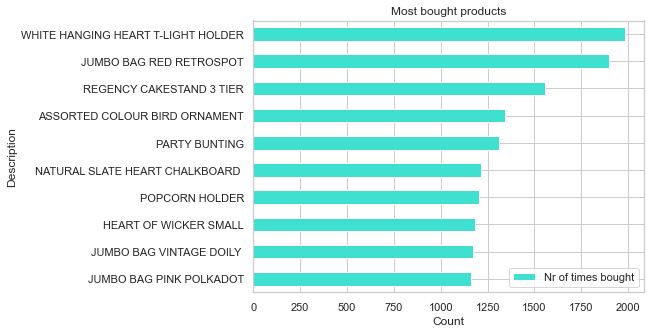

In [202]:
product_sign[['Times_Bought','Description']].set_index(['Description']).sort_values(ascending=False,by='Times_Bought')[:10].sort_values(ascending=True,by='Times_Bought').plot.barh(figsize=(7,5),color='Turquoise')
plt.title('Most bought products')
plt.legend(['Nr of times bought'])
plt.xlabel('Count')

### Create Train and Test

The data was split taking into consideration the order in which the transactions occurred, where the first 85% of the transactions of each customer were used for training and the last 15% for validation. By doing this we are making sure that the model is being tested in more recent transactions. For clients with less than 4 transactions, the rule was changed and the threshold went to 51%, meaning that, for clients with 3 transactions, transaction numbers 2 and 3 will be in validation, and for clients with 2 transactions, only transaction number 2 will be in validation. Note: clients with 1 or 0 transactions weren't used because of the split constraints.  
__x_train_matrix_count -__ counts how many different times  a customer bought a specific product  
__x_train_matrix_bought -__ represents if a customer has ever bought (1) a specific product  
__invoice_train -__ represents the quantity of each product in each transaction  


In [18]:
#getting IDs of clients with more than 1 transaction
multiple_invoices = cust_sig.loc[cust_sig['Nr_Transactions']>1,:].index

In [19]:
#creating a DF to order and count the invoices by cronological order

custID = []
invoicenr = []
count = []
date = []
for i in multiple_invoices:
    #getting the invoices of a specific customer i
    df_count = data_clean.loc[(data_clean['CustId']==i) ,['InvoiceNo','InvDate','CustId']].sort_values(by='InvDate').drop_duplicates()
    #iterate throught the df created and append the respective CustId, InvoiceNo, transaction count and date of transaction
    for  index, invoice,value,Date in zip(df_count['CustId'], df_count['InvoiceNo'],np.arange(1,len(df_count)+1),df_count['InvDate']):
        
        custID.append(index)
        invoicenr.append(invoice)
        count.append(value)
        date.append(Date)
        
#create a DF with the generated data   
count_invoices = pd.DataFrame()
count_invoices['CustId'] = custID
count_invoices['InvoiceNo'] = invoicenr
count_invoices['Count'] = count
count_invoices['Date'] = date

In [20]:
#counting the nr of invoices per customer
total_count = count_invoices.groupby('CustId')['Count'].agg('last').reset_index().rename(columns = {'Count':'Total_Count'})
#merging with count_invoices created above 
count_invoices = pd.merge(count_invoices.copy(), total_count,on='CustId')

In [21]:
#create a variable that represents the percentage of the respective invoice for the total of invoices
count_invoices['pct_value'] = 1/ count_invoices['Total_Count']
#cumsum the percentages to enable a smooth split
split_ = count_invoices.set_index(['CustId','InvoiceNo']).groupby('CustId').cumsum()['pct_value'].reset_index()
split_ = pd.merge(split_, total_count,on='CustId')
split_.rename(columns = {'pct_value':'transaction_%'},inplace=True)

data_split = pd.merge(data_clean.copy(),split_[['InvoiceNo','transaction_%','Total_Count']].copy(), on='InvoiceNo')

In [22]:
def split_data (data,tresh):
    x_train = data.loc[(data['transaction_%']<tresh) & (data['Total_Count']>3)]
    x_val = data.loc[(data['transaction_%']>=tresh) & (data['Total_Count']>3)]
    
    #for clients with less than 4 invoices the split can't be performed on the 85%
    x_train = pd.concat([x_train,data.loc[(data['transaction_%']<0.51) & (data['Total_Count']<=3)]])
    x_val = pd.concat([x_val,data.loc[(data['transaction_%']>=0.51) & (data['Total_Count']<=3)]])
    return(x_train,x_val)

In [23]:
x_train,x_val = split_data(data_split.copy(),0.85)

In [24]:
val_cols = x_val.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).columns
train_cols = x_train.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).columns
cols = set(set(val_cols) & set(train_cols))

#create a m * n matrix to count how many times a customer bought a specific product (m = customers, n = products)
x_train_matrix_count = x_train.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).copy()[cols]
x_train_matrix_csr_count = csr_matrix(x_train_matrix_count)


x_val_matrix_count = x_val.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).copy()[cols]
x_val_matrix_csr_count = csr_matrix(x_val_matrix_count)

C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/1262441276.py:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train_matrix_count = x_train.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).copy()[cols]
C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/1262441276.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_val_matrix_count = x_val.groupby(['CustId','StockCode']).count()['Quantity'].unstack(level ='StockCode').fillna(value=0).copy()[cols]


In [25]:
#create a training and validation set that indicates whether a customer ahas bought a specific product or not 

#count how many times a client has bought a specific product (similar to the datasets above)
x_train_matrix_bought = x_train.groupby(['CustId','StockCode']).count()['Quantity'].copy()
x_train_matrix_bought = x_train_matrix_bought.reset_index()

#replace all the values with 1 because we just want to know if the customer bought the product or not
x_train_matrix_bought.loc[:,'Quantity'] = 1

#unstack to create a m * n matrix (m = customers, n = products)
x_train_matrix_bought = x_train_matrix_bought.set_index(['CustId','StockCode']).unstack('StockCode').fillna(0)
x_train_matrix_bought.columns.names = 'Quantity','StockCode'
x_train_matrix_bought = x_train_matrix_bought.droplevel('Quantity',axis=1)


x_val_matrix_bought = x_val.groupby(['CustId','StockCode']).count()['Quantity'].copy()
x_val_matrix_bought = x_val_matrix_bought.reset_index()
x_val_matrix_bought.loc[:,'Quantity'] = 1
x_val_matrix_bought = x_val_matrix_bought.set_index(['CustId','StockCode']).unstack('StockCode').fillna(0)
x_val_matrix_bought.columns.names = 'Quantity','StockCode'
x_val_matrix_bought = x_val_matrix_bought.droplevel('Quantity',axis=1)

#find columns (products) that intersect in both train and validation sets 
cols_train_bought = x_train_matrix_bought.columns
cols_val_bought = x_val_matrix_bought.columns
cols_bouught = set(set(cols_train_bought) & set(cols_val_bought))

#filter both datasets with their intersecting columns
x_train_matrix_bought = x_train_matrix_bought[cols]
x_val_matrix_bought = x_val_matrix_bought[cols]

#transform the datasets in a csr matrix
x_train_matrix_csr_bought = csr_matrix(x_train_matrix_bought)
x_val_matrix_csr_bought = csr_matrix(x_val_matrix_bought)

C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/878260902.py:29: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train_matrix_bought = x_train_matrix_bought[cols]
C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/878260902.py:30: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_val_matrix_bought = x_val_matrix_bought[cols]


In [26]:
def create_csr (data_train,data_val):
    #this function can be used to create a csr matrix by receiving a train and validation set \
    #in the format n * m 
    train_invoice_cols = data_train.columns
    val_invoice_cols = data_val.columns
    cols =set(set(train_invoice_cols) & set(val_invoice_cols))
    
    data_train = data_train[cols]
    data_train_matrix_csr = csr_matrix(data_train)

    data_val = data_val[cols]
    data_val_matrix_csr = csr_matrix(data_val)
    return(data_train_matrix_csr, data_train, data_val_matrix_csr, data_val)

        
    

In [27]:
invoice_train = x_train.groupby(['InvoiceNo','StockCode']).sum()['Quantity'].unstack('StockCode').fillna(value=0)
invoice_val = x_val.groupby(['InvoiceNo','StockCode']).sum()['Quantity'].unstack('StockCode').fillna(value=0)

In [28]:
x_train_invoice_csr, x_train_invoice,x_val_invoice_csr, x_val_invoice = create_csr(invoice_train, \
                                                 invoice_val)

C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/334918867.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_train = data_train[cols]
C:\Users\rafae\AppData\Local\Temp/ipykernel_14284/334918867.py:11: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  data_val = data_val[cols]


In [29]:
train_invoice_cols = x_train.groupby(['InvoiceNo','StockCode']).sum()['Quantity'].unstack('StockCode').fillna(value=0).columns
val_invoice_cols = x_val.groupby(['InvoiceNo','StockCode']).sum()['Quantity'].unstack('StockCode').fillna(value=0).columns


### Modelling
The modeling stage can be divided into 4 parts, 
- 1st is a recommender addressing the cold start problem, where recommendations are performed taking into consideration the products bought by the most versatile customer in the country of the target customer. (For eg: if a new customer from Portugal arrives then we will look for the Portuguese customer that bought more products and recommend accordingly.
- 2nd ALS model with 2 functions, ALS_recommender trains and performs validation and the recommend_ALS performs recommendations
- 3rd, The  LightFM stage is divided into 3 parts, one for the cold start problem (where the model is trained with user features), the other, the model is trained without the user features, and another for item-item recommendations based on the cosine similarity. lighfm_recommender trains and validates the model, sample_recommendation_user recommends items using the lighfm model, recommend_with_items performs item-item recommendation and cold_start_rec performs recommendations for cold start customers.
- 4th Association Rules using an invoice matrix (Association), where in each transaction a product gets the value 1 if it was bought. The goal here is to perform recommendations based on items present in the rules (eg: if a customer is in the checkout area and has an item-set in his basket that is part of good rule, then we would recommend the remaining items of the rule to the customers (the number of recommendation is then limited by s threshold with the goal of filtering the best recommendations and not overwhelming the customer with recommendations) 



### Cold Start

#### While applying cold start we cannot use the customer id to execute the code because the customer may not be in the database

In [185]:
custId = []
nr_trans = []
country = []
for i in cust_sig['Country'].unique():
    custId.append(cust_sig.loc[cust_sig['Country']==f'{i}'].sort_values(ascending=False,by='Products_Bough').iloc[0].name)
    country.append(cust_sig.loc[cust_sig['Country']==f'{i}'].sort_values(ascending=False,by='Products_Bough').iloc[0]['Country'])
    nr_trans.append(cust_sig.loc[cust_sig['Country']==f'{i}'].sort_values(ascending=False,by='Products_Bough').iloc[0]['Products_Bough'])
    
cold_start = pd.DataFrame()
cold_start['CustID'] = custId
cold_start['Country'] = country
cold_start['Products_Bough'] = nr_trans

In [187]:
country_name = 'Portugal'
most_valuableID = cold_start.loc[cold_start['Country']==country_name,'CustID']
lenght_products = len(data_clean.loc[data_clean['CustId'].isin(most_valuableID),'Description'].value_counts())
to_recommend = []
if lenght_products < 5:
    to_recommend.append(data_clean.loc[data_clean['CustId'].isin(most_valuableID),'Description'].value_counts().index)
    to_recommend.append(data_clean.loc[: ,'Description'].value_counts().iloc[:(5-lenght_products)])
else:
    to_recommend.append(data_clean.loc[data_clean['CustId'].isin(most_valuableID),'Description'].value_counts().index[:5].values)
    
cold_recomender = pd.DataFrame()
recommend = []
for i in to_recommend[0]:
    
    recommend.append(i)

cold_recomender['Products'] = recommend
cold_recomender['Origin Country'] = str(country_name)

print(to_recommend)
display(cold_recomender)

[array(['LUNCH BAG VINTAGE DOILY ', 'LUNCH BAG PINK POLKADOT',
       'PLASTERS IN TIN VINTAGE PAISLEY ', 'LUNCH BAG CARS BLUE',
       'LUNCH BAG RED RETROSPOT'], dtype=object)]


,Products,Origin Country
0,LUNCH BAG VINTAGE DOILY,Portugal
1,LUNCH BAG PINK POLKADOT,Portugal
2,PLASTERS IN TIN VINTAGE PAISLEY,Portugal
3,LUNCH BAG CARS BLUE,Portugal
4,LUNCH BAG RED RETROSPOT,Portugal


### ALS Model for Users

In [30]:
from implicit.evaluation import precision_at_k, train_test_split,AUC_at_k,mean_average_precision_at_k

In [31]:
def ALS_Recommender (model,alpha, data_train,data_val):
    from implicit.als import AlternatingLeastSquares
    from implicit.nearest_neighbours import bm25_weight

    # weight the matrix, both to reduce impact of users that have played the same artist thousands of times
    # and to reduce the weight given to popular items
    data_train = bm25_weight(data_train, K1=100, B=0.8)
    
    from implicit.evaluation import precision_at_k, train_test_split,AUC_at_k,mean_average_precision_at_k
    model_ALS = model
    alpha_val = alpha
    data_conf = (data_train * alpha_val).astype('double')
    # Calculate the confidence by multiplying it by our alpha value.
    # Fit the model
    model_ALS.fit(data_conf,show_progress=False)
    precision = precision_at_k(model_ALS, data_train, data_val, K=10, num_threads=4,show_progress=False)
    AUC = AUC_at_k(model_ALS, data_train, data_val, K=10, num_threads=4,show_progress=False)
    #mean average precision
    MAP = mean_average_precision_at_k(model_ALS, data_train, data_val, K=10, num_threads=4,show_progress=False)
    print(f'Precision at 10 Score : {precision}')
    print(f'MAP at 10 Score : {MAP}')
    print(f'AUC at 10 Score : {AUC}')
    return(model_ALS)


def recommend_ALS (model,user_id,data_matrix, data_train,index_name, N=10 ):
    data_clean = data_train.copy()
    us_id = np.argwhere(data_matrix.index == user_id)[0][0]
    to_recommend_index , prod_scores = model.recommend(userid=us_id,user_items=x_train_matrix_csr_bought, N=N+30, filter_already_liked_items=False )


    prod_indexes = []
    for i in to_recommend_index:
        prod_indexes.append(data_matrix.columns[i])

    description = []
    for i in prod_indexes:    
        description.append(data_clean.loc[data_clean['StockCode']==i,'Description'].unique())

    bought = data_clean.loc[data_clean[f'{index_name}']==user_id,'StockCode'].unique()
    bought_description = data_clean.loc[data_clean[f'{index_name}']==user_id,'Description'].unique()
    
    rec_index = []
    rec_description = []
    for i,ii in zip(prod_indexes,description):
        if len(rec_index)<10:
            if i not in bought:
                rec_index.append(i)
                rec_description.append(ii[0])
            
            


    print(f'The Customer {user_id} has bought:')
    for index, i in enumerate(bought_description):
        print(f'{index+1} - {i}')
    counter =0

    print('-'*125)

    print(f'The top {10} recommendations are:')
    for i,ii in zip(rec_description,rec_index):
        counter = counter +1
        print(f'{counter} - {i}, with category {ii[:2]}')
    als_rec = pd.DataFrame()
    als_rec['ItemID'] = rec_index
    als_rec['Description'] = rec_description
    return(als_rec.set_index('ItemID'))

#### Performing ALS on the Invoice Dataframe

In [42]:
ALL_USERS = data_clean['CustId'].unique().tolist()
ALL_ITEMS = data_clean['StockCode'].unique().tolist()

user_ids = dict(list(enumerate(ALL_USERS)))
item_ids = dict(list(enumerate(ALL_ITEMS)))

user_map = {u: uidx for uidx, u in user_ids.items()}
item_map = {i: iidx for iidx, i in item_ids.items()}

df = data_clean.copy()
df['user_id'] = df['CustId'].map(user_map)
df['item_id'] = df['StockCode'].map(item_map)

In [45]:
def to_user_item_coo(df):
    """ Turn a dataframe with transactions into a COO sparse items x users matrix"""
    row = df['user_id'].values
    col = df['item_id'].values
    data = np.ones(df.shape[0])
    coo_train = coo_matrix((data, (row, col)), shape=(len(ALL_USERS), len(ALL_ITEMS)))
    coo_train

    return coo_train

train_coo = to_user_item_coo(df.loc[df['InvoiceNo'].isin(x_train['InvoiceNo'].unique())])
val_coo  = to_user_item_coo(df.loc[df['InvoiceNo'].isin(x_val['InvoiceNo'].unique())])

In [46]:
csr_train = train_coo.tocsr()
csr_val = val_coo.tocsr()

In [53]:
als_model = implicit.als.AlternatingLeastSquares(factors=50, regularization=1, \
                                                     iterations=100,num_threads=2,\
                                                     random_state=10)
model_ALS_invoice = ALS_Recommender(als_model,5,train_coo,csr_val,)

Precision at 10 Score : 0.07696377696377696
MAP at 10 Score : 0.03231946966046163
AUC at 10 Score : 0.5144644165941307


In [53]:
als_model = implicit.als.AlternatingLeastSquares(factors=20, regularization=1, \
                                                     iterations=100,num_threads=2,\
                                                     random_state=10)
model_ALS_invoice = ALS_Recommender(als_model,2,x_train_invoice_csr,x_val_invoice_csr,)

D:\Rafael\Anaconda_Setup\envs\Personal\lib\site-packages\implicit\utils.py:31: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


Precision at 10 Score : 0.02660355802187041
MAP at 10 Score : 0.009342928985607967
AUC at 10 Score : 0.5046988922739514


#### Performing ALS on the customer Dataframe

##### Using Count Matrix

In [51]:
als_model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.05, \
                                                     iterations=20,num_threads=0,\
                                                     random_state=10)
model_ALS = ALS_Recommender(als_model,2,x_train_matrix_csr_count,x_val_matrix_csr_count)

Precision at 10 Score : 0.07563606757581925
MAP at 10 Score : 0.032605623696157576
AUC at 10 Score : 0.513019024353505


##### Using Bough Matrix

In [55]:
als_model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.05, \
                                                     iterations=100,num_threads=0,\
                                                     random_state=10)
model_ALS = ALS_Recommender(als_model,2,x_train_matrix_csr_bought,x_val_matrix_csr_bought)

Precision at 10 Score : 0.08080602483207816
MAP at 10 Score : 0.034308977486416474
AUC at 10 Score : 0.5136423740518087


#### ALS Recomendation

In [56]:
user_nr = 18272.0
recommend_ALS(model_ALS,user_nr,x_val_matrix_bought,x_train,'CustId',N=20)

The Customer 18272.0 has bought:
1 - RETROSPOT RED WASHING UP GLOVES
2 - RED HEART SHAPE LOVE BUCKET 
3 - HANGING JAM JAR T-LIGHT HOLDER
4 - PLASTERS IN TIN VINTAGE PAISLEY 
5 - PANTRY WASHING UP BRUSH
6 - PANTRY SCRUBBING BRUSH
7 - BLUE POLKADOT WASHING UP GLOVES
8 - FUNKY WASHING UP GLOVES ASSORTED
9 - SET 2 PANTRY DESIGN TEA TOWELS
10 - PANTRY ROLLING PIN
11 - SET OF 4 PANTRY JELLY MOULDS
12 - SET OF 4 JAM JAR MAGNETS
13 - RED POLKADOT BEAKER 
14 - RED POLKADOT COFFEE  MUG
15 - BLUE POLKADOT BEAKER 
16 - BLUE POLKADOT COFFEE MUG
17 - RECIPE BOX PANTRY YELLOW DESIGN
18 - JAM JAR WITH PINK LID
19 - JAM JAR WITH GREEN LID
20 - PACK OF 20 NAPKINS PANTRY DESIGN
21 - 3 TRADITIONAl BISCUIT CUTTERS  SET
22 - JAM MAKING SET WITH JARS
23 - SET OF 6 SPICE TINS PANTRY DESIGN
24 - GINGERBREAD MAN COOKIE CUTTER
25 - HOMEMADE JAM SCENTED CANDLES
26 - PLASTERS IN TIN WOODLAND ANIMALS
27 - CHILDRENS CUTLERY RETROSPOT RED 
28 - CHILDRENS CUTLERY POLKADOT PINK
29 - CHILDRENS CUTLERY POLKADOT GREEN 
30

,Description
ItemID,
23307,SET OF 60 PANTRY DESIGN CAKE CASES
22720,SET OF 3 CAKE TINS PANTRY DESIGN
22624,IVORY KITCHEN SCALES
23243,SET OF TEA COFFEE SUGAR TINS PANTRY
23308,SET OF 60 VINTAGE LEAF CAKE CASES
22847,BREAD BIN DINER STYLE IVORY
22952,60 CAKE CASES VINTAGE CHRISTMAS
22625,RED KITCHEN SCALES
22956,36 FOIL HEART CAKE CASES


### LightFm Model 

In [59]:
def create_id (data):
    user = data.index     
    product = data.columns
    
    user_ = {}
    for i,ii in enumerate(user):
        user_[i] = ii
        
    prod_2 = {}
    for i , ii in zip(product_sign.index, product_sign['Description']):
        prod_2[i] = ii
    return(user_,prod_2)

In [60]:
def lighfm_recommender (model,data_train_matrix, data_val_matrix,data_train,epochs,user_feat=None, k=10):
    #this function receives 2 matirxes in csr format and a DF to create the item similarity matrix
    from sklearn.metrics.pairwise import cosine_similarity
    import lightfm
    from scipy import sparse
    from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
    #ceate and train model  
    model_light=model
    model_light.fit(data_train_matrix,num_threads=4,epochs=epochs,user_features = user_feat)
    
    #create similarity matrix between items
    item_df = sparse.csr_matrix(model_light.item_embeddings)
    item_distance = pd.DataFrame(cosine_similarity(item_df), columns =data_train.columns, index = data_train.columns )

    # Model Assess
    precision_test = precision_at_k(model=model_light,test_interactions=data_val_matrix,user_features=user_feat,k=k,).mean()
    precision_train = precision_at_k(model=model_light,test_interactions=data_train_matrix,user_features=user_feat,k=k,).mean()
    recall_test = recall_at_k(model=model_light,test_interactions=data_val_matrix,user_features=user_feat,k=k).mean()
    recall_train = recall_at_k(model=model_light,test_interactions=data_train_matrix,user_features=user_feat,k=k,).mean()
    auc_train = auc_score(model=model_light, test_interactions=data_train_matrix,user_features=user_feat).mean()
    auc_test = auc_score(model=model_light,test_interactions=data_val_matrix,user_features=user_feat).mean()

    print(f"Train AUC Score: {auc_train}")
    print(f"Test AUC Score: {auc_test}")
    print('-'*125)
    print(f'Train Precision at {k} Score: {precision_train}')
    print(f'Test Precision {k} Score: {precision_test}')
    print('')
    print(f'Train Recall {k} Score: {recall_train}')
    print(f'Test Recall {k} Score: {recall_test}')
    return(model_light,item_distance)


#https://towardsdatascience.com/recommendation-system-in-python-lightfm-61c85010ce17
def sample_recommendation_user(model, interactions, interaction_id, user_dict, 
                               item_dict,threshold = 0,nrec_items = 5, show = True,user_feat = None):
    
    n_users, n_items = interactions.shape
    interaction_id = interaction_id
    user_id = user_idx[interaction_id]
    scores = pd.Series(model.predict(interaction_id,np.arange(n_items),user_features=user_feat))
    scores.index = interactions.columns
    
    
    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    scores = scores.sort_values(ascending=False)
    to_recommend = []
    score = []
    description = []
    
    appended = []
    for i,ii in zip(scores.index, scores):
        if len(appended)<15:
            if i not in known_items:
                to_recommend.append(i)
                score.append(ii)
                description.append(data_clean.loc[data_clean['StockCode'].isin([i]),'Description'].unique()[0])
                appended.append(0)

        
    
    lightRecom = pd.DataFrame()
    lightRecom['ProductID'] = to_recommend
    lightRecom['Description'] = description
    lightRecom['Score'] = score
    display(lightRecom.iloc[:10])
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    if show == True:
        print ("User: " + str(user_id))
        print("Has Previosly Bought:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter+=1
            
            
        print("\n Recommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter+=1
    return(lightRecom)


def recommend_with_items (similarities, item_Id,k):
    #this function receives a similarity matrix and recommends k items based on a target item_id
    
    target_item = data_clean.loc[data_clean['StockCode']==f'{item_Id}','Description'].unique()
    scores = similarities[f'{item_Id}'].sort_values(ascending=False)[1:k+1]
    scores_id = scores.index
    description = []
    for i in scores_id:
        id_ = data_clean.loc[data_clean['StockCode']==f'{i}','Description'].unique()
        description.append(id_[0])
    to_recommend = pd.DataFrame(index = scores_id)
    to_recommend['Description'] = description
    to_recommend['Score'] = scores.values
    print(f'The {k} most similar item to item {target_item[0]} are:')
    for i,ii in enumerate(description):
        print(f'{i+1} - {ii}')
    return(to_recommend)
    

def cold_start_rec (model,user_id,item_dict, user_feature,nrec_items,columns):
    scores= model.predict(user_id,item_ids=np.arange(len(columns)), user_features=user_feature)
    products = columns
    scores = pd.Series(scores)
    scores.index = products
    scores = scores.sort_values(ascending=False)
    to_recommend = []
    score = []
    description = []
    known_items = []

    appended = []
    for i,ii in zip(scores.index, scores):
        if len(appended)<15:
            if i not in known_items:
                to_recommend.append(i)
                score.append(ii)
                description.append(data_clean.loc[data_clean['StockCode'].isin([i]),'Description'].unique()[0])
                appended.append(0)



    lightRecom = pd.DataFrame()
    lightRecom['ProductID'] = to_recommend
    lightRecom['Description'] = description
    lightRecom['Score'] = score
    display(lightRecom.iloc[:10])
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))
    
    print ("User: " + str(user_id))
    print("Has Previosly Bought:")
    counter = 1
    for i in known_items:
        print(str(counter) + '-' + i)
        counter+=1


    print("\n Recommended Items:")
    counter = 1
    for i in scores:
        print(str(counter) + '-' + i)
        counter+=1
    return(lightRecom)

In [61]:
user_idx, prod_idx2 = create_id(x_train_matrix_bought)

#### Modelling Training 

In [62]:
def oneHotEncoder(data):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
    non_metric_features =list(data.select_dtypes(exclude=np.number).set_index(data.index).columns)
    ohc = OneHotEncoder(sparse=False)
    ohc_feat = ohc.fit_transform(data[non_metric_features])
    names = ohc.get_feature_names()
    
    ohc_cat = pd.DataFrame(data =ohc_feat ,columns = names, index = data.index)
    return(ohc_cat)

def create_feature_matrix (data,features):
    user_feat = data.copy()
    user_feat = user_feat[features]
    user_feature = csr_matrix(oneHotEncoder_(user_feat))
    return(user_feature)




In [63]:
user_feat = cust_sig.reset_index().copy()
user_feat = user_feat.loc[user_feat['CustId'].isin(x_train_matrix_bought.index),['CustId','Country']]
user_feature0 = csr_matrix(oneHotEncoder(user_feat))

#### With User Features

In [73]:
model_fm = lightfm.LightFM(loss='warp',no_components=200,learning_rate=0.02,random_state=10)
lightfm_model_features, item_sim = lighfm_recommender(model_fm,x_train_matrix_csr_bought \
                                                      ,x_val_matrix_csr_bought,x_train_matrix_bought \
                                                      ,user_feat = user_feature0,epochs=3)

Train AUC Score: 0.7921098470687866
Test AUC Score: 0.7899875640869141
-----------------------------------------------------------------------------------------------------------------------------
Train Precision at 10 Score: 0.1612999141216278
Test Precision 10 Score: 0.08569074422121048

Train Recall 10 Score: 0.03954366978926895
Test Recall 10 Score: 0.04198074349862535


#### Cold Start Recommendation

The LightFM model can be used to perform cold start recommendations since it allows the introduction of user and item features, enabling the model to gain knowledge on customers or items without any interaction present.  In this example, the algorith is using country data to make predictions on recommended items. 

In [74]:
#create feature user of customers without customer id or with only 1 transaction
user_feat = data_clean.loc[((data_clean['CustId'].isin(split_['CustId'])==False) | \
                           (data_clean['CustId'].isnull()==True)) & (data_clean['Country'].isin(x_train['Country'].unique()))].copy()

user_feat = user_feat[['CustId','Country']].drop_duplicates()
index_ = user_feat.index
user_feature = csr_matrix(oneHotEncoder(user_feat))

In [75]:
cold_start_rec(lightfm_model_features,1,prod_idx2,user_feature,10,x_train_matrix_bought.columns)

,ProductID,Description,Score
0,22423,REGENCY CAKESTAND 3 TIER,1.295774
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1.217632
2,47566,PARTY BUNTING,1.061069
3,85099B,JUMBO BAG RED RETROSPOT,0.979936
4,84879,ASSORTED COLOUR BIRD ORNAMENT,0.965192
5,21212,PACK OF 72 RETROSPOT CAKE CASES,0.948233
6,22720,SET OF 3 CAKE TINS PANTRY DESIGN,0.929359
7,22457,NATURAL SLATE HEART CHALKBOARD,0.883519
8,22086,PAPER CHAIN KIT 50'S CHRISTMAS,0.863836
9,23203,JUMBO BAG VINTAGE DOILY,0.808531


User: 1
Has Previosly Bought:

 Recommended Items:
1- REGENCY CAKESTAND 3 TIER
2- WHITE HANGING HEART T-LIGHT HOLDER
3- PARTY BUNTING
4- JUMBO BAG RED RETROSPOT
5- ASSORTED COLOUR BIRD ORNAMENT
6- PACK OF 72 RETROSPOT CAKE CASES
7- SET OF 3 CAKE TINS PANTRY DESIGN 
8- NATURAL SLATE HEART CHALKBOARD 
9- PAPER CHAIN KIT 50'S CHRISTMAS 
10- JUMBO BAG VINTAGE DOILY 


C:\Users\rafae\AppData\Local\Temp/ipykernel_10912/990427466.py:139: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))


,ProductID,Description,Score
0,22423,REGENCY CAKESTAND 3 TIER,1.295774
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1.217632
2,47566,PARTY BUNTING,1.061069
3,85099B,JUMBO BAG RED RETROSPOT,0.979936
4,84879,ASSORTED COLOUR BIRD ORNAMENT,0.965192
5,21212,PACK OF 72 RETROSPOT CAKE CASES,0.948233
6,22720,SET OF 3 CAKE TINS PANTRY DESIGN,0.929359
7,22457,NATURAL SLATE HEART CHALKBOARD,0.883519
8,22086,PAPER CHAIN KIT 50'S CHRISTMAS,0.863836
9,23203,JUMBO BAG VINTAGE DOILY,0.808531


#### Without User Features

In [223]:

for i in [0.001,0.005,0.01,0.02,0.05]:
    print(f'Learing Rate: {i}')
    model_fm = lightfm.LightFM(loss='warp',no_components=200,learning_rate=i)
    lightfm_model, item_sim = lighfm_recommender(model_fm,x_train_matrix_csr_bought,x_val_matrix_csr_bought,x_train_matrix_bought,2)
    print('-'*125)

Learing Rate: 0.001
Train AUC Score: 0.7750322818756104
Test AUC Score: 0.7742590308189392
-----------------------------------------------------------------------------------------------------------------------------
Train Precision at 10 Score: 0.15755628049373627
Test Precision 10 Score: 0.08700000494718552

Train Recall 10 Score: 0.04004647082077853
Test Recall 10 Score: 0.039703927204398415
-----------------------------------------------------------------------------------------------------------------------------
Learing Rate: 0.005
Train AUC Score: 0.7828736901283264
Test AUC Score: 0.7837705612182617
-----------------------------------------------------------------------------------------------------------------------------
Train Precision at 10 Score: 0.14933906495571136
Test Precision 10 Score: 0.08900000154972076

Train Recall 10 Score: 0.03426313850384154
Test Recall 10 Score: 0.03693922131713017
-------------------------------------------------------------------------------

In [535]:
for i in [50,100,200,500]:
    print(f'Nr Components: {i}')
    model_fm = lightfm.LightFM(loss='warp',no_components=i,learning_rate=0.02,random_state=10)
    lightfm_model, item_sim = lighfm_recommender(model_fm,x_train_matrix_csr_bought,x_val_matrix_csr_bought,x_train_matrix_bought,2)
    print('-'*125)

Nr Components: 50
Train AUC Score: 0.7943669557571411
Test AUC Score: 0.7913122773170471
-----------------------------------------------------------------------------------------------------------------------------
Test Precision Score: 0.09825000166893005
Test Recall Score: 0.042982089332289045
-----------------------------------------------------------------------------------------------------------------------------
Nr Components: 100
Train AUC Score: 0.8042321801185608
Test AUC Score: 0.7978204488754272
-----------------------------------------------------------------------------------------------------------------------------
Test Precision Score: 0.10803571343421936
Test Recall Score: 0.048164666960329776
-----------------------------------------------------------------------------------------------------------------------------
Nr Components: 200
Train AUC Score: 0.8138183355331421
Test AUC Score: 0.802442193031311
----------------------------------------------------------------

In [71]:
model_fm = lightfm.LightFM(loss='warp',no_components=200,learning_rate=0.02,random_state=10)
lightfm_model, item_sim = lighfm_recommender(model_fm,x_train_matrix_csr_count,x_val_matrix_csr_count,x_train_matrix_count,3,k=20)


Train AUC Score: 0.8385251760482788
Test AUC Score: 0.8148438334465027
-----------------------------------------------------------------------------------------------------------------------------
Train Precision at 20 Score: 0.21827778220176697
Test Precision 20 Score: 0.10502803325653076

Train Recall 20 Score: 0.10465915418920389
Test Recall 20 Score: 0.1012242038093104


In [65]:
user_id = 12348.0
arg_id  = int(np.argwhere(x_train_matrix_bought.index== user_id)[0][0])

In [72]:
recommendation = sample_recommendation_user(lightfm_model,x_val_matrix_bought,arg_id ,user_idx,prod_idx2,nrec_items=10)

,ProductID,Description,Score
0,20725,LUNCH BAG RED RETROSPOT,2.713674
1,22382,LUNCH BAG SPACEBOY DESIGN,2.648777
2,85099B,JUMBO BAG RED RETROSPOT,2.612767
3,20726,LUNCH BAG WOODLAND,2.551939
4,20727,LUNCH BAG BLACK SKULL.,2.534981
5,21212,PACK OF 72 RETROSPOT CAKE CASES,2.506015
6,23206,LUNCH BAG APPLE DESIGN,2.432791
7,22383,LUNCH BAG SUKI DESIGN,2.389974
8,23209,LUNCH BAG VINTAGE DOILY,2.388830
9,22384,LUNCH BAG PINK POLKADOT,2.380080


User: 12348.0
Has Previosly Bought:
1- ICE CREAM PEN LIP GLOSS 
2- DOUGHNUT LIP GLOSS 

 Recommended Items:
1- LUNCH BAG RED RETROSPOT
2- LUNCH BAG SPACEBOY DESIGN 
3- JUMBO BAG RED RETROSPOT
4- LUNCH BAG WOODLAND
5- LUNCH BAG  BLACK SKULL.
6- PACK OF 72 RETROSPOT CAKE CASES
7- LUNCH BAG APPLE DESIGN
8- LUNCH BAG SUKI DESIGN 
9- LUNCH BAG VINTAGE DOILY 
10- LUNCH BAG PINK POLKADOT


#### Item - Item Recommendation

In [43]:
item_sim

StockCode,20760,23047,22524,35653,22313,23042,22221,35810A,22928,21738,...,84870C,84247E,22853,23086,85088,22287,23272,23134,22353,90142D
StockCode,,,,,,,,,,,,,,,,,,,,,
20760,1.000000,0.832100,0.136609,0.912501,0.476168,0.850525,0.390048,-0.470470,0.341942,0.736280,...,0.907603,0.931884,-0.556887,0.748374,0.922065,0.065001,0.603716,0.137927,0.431438,0.878688
23047,0.832100,1.000000,0.377505,0.862966,0.247816,0.964592,0.439238,-0.245071,0.207437,0.712284,...,0.882237,0.872283,-0.242870,0.706814,0.788095,-0.161611,0.520323,0.260442,0.551071,0.790725
22524,0.136609,0.377505,1.000000,0.113845,-0.207961,0.354067,0.389561,0.034077,-0.376149,-0.141455,...,0.067042,0.111505,-0.038081,0.022102,0.134522,-0.477895,0.091055,-0.012411,0.643507,-0.060064
35653,0.912501,0.862966,0.113845,1.000000,0.530587,0.897869,0.604402,-0.267050,0.433695,0.828275,...,0.967627,0.948557,-0.339494,0.856866,0.844750,0.129433,0.633368,0.398414,0.262277,0.942430
22313,0.476168,0.247816,-0.207961,0.530587,1.000000,0.290719,0.372224,0.035487,0.076634,0.552619,...,0.433325,0.459646,-0.336445,0.434324,0.534483,0.504089,0.267024,0.435322,0.008066,0.517573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22287,0.065001,-0.161611,-0.477895,0.129433,0.504089,-0.036381,-0.017986,0.403737,0.396183,0.351002,...,0.138705,0.202413,0.255605,0.445484,0.085405,1.000000,0.470731,0.541845,-0.501182,0.348367
23272,0.603716,0.520323,0.091055,0.633368,0.267024,0.645589,0.353723,0.066374,0.662977,0.545359,...,0.683356,0.739287,0.022505,0.870204,0.531575,0.470731,1.000000,0.439454,-0.070868,0.761666
23134,0.137927,0.260442,-0.012411,0.398414,0.435322,0.331310,0.404647,0.615956,0.198567,0.519003,...,0.330733,0.338210,0.502994,0.561725,0.191758,0.541845,0.439454,1.000000,-0.217084,0.426119


In [44]:
recommend_with_items(item_sim,'23272',20)

The 20 most similar item to item TREE T-LIGHT HOLDER WILLIE WINKIE are:
1 - PINK/WHITE CHRISTMAS TREE 60CM
2 - SWEETHEART WALL TIDY 
3 - SET OF 2 CERAMIC CHRISTMAS TREES
4 - PURPLE ENAMEL FLOWER RING
5 - ORIGAMI JASMINE INCENSE/CANDLE SET
6 - ORIGAMI VANILLA INCENSE/CANDLE SET 
7 - GREEN ROUND COMPACT MIRROR
8 - EMBOSSED HEART TRINKET BOX
9 - MINT GREEN ROSE TOWEL
10 - SOFT PINK ROSE TOWEL 
11 - DOORMAT CHRISTMAS VILLAGE
12 - PORCELAIN ROSE SMALL
13 - RIDGED GLASS POSY VASE 
14 - TALL ROCOCO CANDLE HOLDER
15 - STORAGE TIN HOME SWEET HOME
16 - FOLK ART METAL STAR T-LIGHT HOLDER
17 - 4 PINK DINNER CANDLE SILVER FLOCK
18 - STAR  T-LIGHT HOLDER 
19 - ROSE DU SUD COSMETICS BAG
20 - DAISY JOURNAL 


,Description,Score
StockCode,,
35598D,PINK/WHITE CHRISTMAS TREE 60CM,0.960773
23460,SWEETHEART WALL TIDY,0.940562
23269,SET OF 2 CERAMIC CHRISTMAS TREES,0.932482
90201A,PURPLE ENAMEL FLOWER RING,0.926610
17012B,ORIGAMI JASMINE INCENSE/CANDLE SET,0.916996
17012A,ORIGAMI VANILLA INCENSE/CANDLE SET,0.909012
84877B,GREEN ROUND COMPACT MIRROR,0.906617
23074,EMBOSSED HEART TRINKET BOX,0.906333
84913B,MINT GREEN ROSE TOWEL,0.904052


In [1081]:
n_cust = len(x_train['CustId'].unique())
n_products = len(x_train['New_Product_ID'].unique()) 


#### Create Association Rules for Invoices

In [25]:
#create association rules df
association = data_clean.groupby(['InvoiceNo','StockCode'])['Quantity'].count()

#making sure that each stock products only appears once per invoice 
association.loc[:] = 1

#unstack df
association = association.unstack(level='StockCode').fillna(value=0)

#### Association Rules on Invoices

In [27]:
frq_items = apriori(association.astype(bool), min_support=0.01 ,use_colnames = True)

In [28]:
rules = association_rules(frq_items,metric='lift', \
                          min_threshold = 1, \
                          support_only=False,)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])


In [29]:
antecedets = []
for i in rules['antecedents']:
    temp_ant =  []
    for ii in i:
        temp_ant.append(ii)
    antecedets.append(temp_ant)
consequents = []       
for i in rules['consequents']:
    temp_cons =  []
    for ii in i:
        temp_cons.append(ii)
    consequents.append(temp_cons)

    
rules_ = pd.DataFrame()
rules_['Antecedent'] = antecedets
rules_['Consequent'] = consequents
rules_['Support'] = rules['support']
rules_['Confidence'] = rules['confidence']
rules_['Lift'] = rules['lift']
rules_['Leverage'] = rules['leverage']

#for lift, support, leverage in zip(rules['lift'],rules['support'],rules['leverage']):

In [47]:
def recommendation_associations (car_number,k):
    #set invoice number or cart id in cases where the transaction is still happening 
    set_invoice = car_number
    products = data_clean.loc[data_clean['InvoiceNo']==set_invoice,'StockCode'].unique()
    
    #create lists to store the stockcode and the score of the relationship
    to_recommend = []
    scores = []
    #iterate throught the products of the invoice 
    for i in products: 
        for antecedent ,consequent,score in zip(rules_['Antecedent'].values,rules_['Consequent'].values, rules_['Confidence'].values):
            #chech iof the a products matches an antecedent of one of the rules
            for antecedent_value in antecedent:
                #print(i)
                if i == antecedent_value:

                    #add the remaining antecedents to the recommendation list
                    value =np.array(antecedent)
                    
                    #add the consequent to the recommendation list
                    recommend = [value, consequent]
                    
                    #eliminate products that are already in the basket from the reommendation list 
                    for rec in recommend[1]:
                        if (rec not in products) & (rec not in to_recommend):
                            to_recommend.append(rec)
                            scores.append(score)
    #get the description of the recommended items 
    description = []                   
    for i in to_recommend:
        desc = data_clean.loc[data_clean['StockCode'].isin([i]),'Description'].unique()[0]
        description.append(desc)
        
    #create a df and print the results
    assoc_rec = pd.DataFrame() 
    assoc_rec['StockCode'] = to_recommend
    assoc_rec['Description'] = description
    assoc_rec['Confidence'] =scores
    assoc_rec = assoc_rec.sort_values(by='Confidence',ascending=False)[:k]

    print(f'The client with invoice nr {set_invoice} has in the cart:')
    counter = 0
    for i in products:
        counter = counter+1
        item = data_clean.loc[data_clean['StockCode'].isin([i]),'Description'].unique()[0]
        print(f'{counter} - {item}')

    print('')
    print('-'*125)
    print('')
    counter = 0
    print(f'Our {len(assoc_rec)} top recommendations are:')
    for i in assoc_rec['StockCode']:
        counter = counter+1
        item = data_clean.loc[data_clean['StockCode'].isin([i]),'Description'].unique()[0]
        print(f'{counter} - {item}')
        
    return(assoc_rec)



In [51]:
recommendation_associations('536375',10)

The client with invoice nr 536375 has in the cart:
1 - WHITE HANGING HEART T-LIGHT HOLDER
2 - WHITE METAL LANTERN
3 - CREAM CUPID HEARTS COAT HANGER
4 - EDWARDIAN PARASOL RED
5 - RETRO COFFEE MUGS ASSORTED
6 - VINTAGE BILLBOARD LOVE/HATE MUG
7 - WOOD S/3 CABINET ANT WHITE FINISH
8 - WOODEN PICTURE FRAME WHITE FINISH
9 - KNITTED UNION FLAG HOT WATER BOTTLE
10 - RED WOOLLY HOTTIE WHITE HEART.
11 - SET 7 BABUSHKA NESTING BOXES

-----------------------------------------------------------------------------------------------------------------------------

Our 10 top recommendations are:
1 - JUMBO BAG RED RETROSPOT
2 - LUNCH BAG SPACEBOY DESIGN 
3 - CLOTHES PEGS RETROSPOT PACK 24 
4 - SET OF 4 PANTRY JELLY MOULDS
5 - POPCORN HOLDER
6 - NATURAL SLATE HEART CHALKBOARD 
7 - REGENCY CAKESTAND 3 TIER
8 - BATHROOM METAL SIGN
9 - JAM MAKING SET PRINTED
10 - LUNCH BAG CARS BLUE


,StockCode,Description,Confidence
2,85099B,JUMBO BAG RED RETROSPOT,0.943396
22,22382,LUNCH BAG SPACEBOY DESIGN,0.776632
23,22558,CLOTHES PEGS RETROSPOT PACK 24,0.753333
13,22993,SET OF 4 PANTRY JELLY MOULDS,0.726950
7,22197,POPCORN HOLDER,0.712871
1,22457,NATURAL SLATE HEART CHALKBOARD,0.708633
6,22423,REGENCY CAKESTAND 3 TIER,0.659933
28,82580,BATHROOM METAL SIGN,0.649425
11,22961,JAM MAKING SET PRINTED,0.605405
25,20728,LUNCH BAG CARS BLUE,0.604278
